In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from riboformer_utils import *
# Read the DNA sequence and the GFF file
sequence_iter = fasta_iter("/home/zzz0054/chen_data/Riboformer/datasets/AA/Arabidopsis_thaliana.TAIR10.dna.toplevel.fasta")
# for header, seq in sequence_iter:
#     print("Genome seq length:", len(seq))

seq = next(sequence_iter)[1]

annotations = np.genfromtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/gff.csv", delimiter="\t")

pause_score_benchmark = {}
L_score_benchmark0 = {}
L_score_benchmark1 = {}

1 dna:chromosome chromosome:TAIR10:1:1:30427671:1 REF


In [2]:
def process_experiment(densities, zc, ypred, annotations, seq, pause_scores_aa, read_type):
    """Process an experiment by calculating pause scores and returning the results."""
    # densities = read_gene_densities(file_paths['data_folder'], file_paths[exp_name], suffixes)
    # zc = np.loadtxt(file_paths['data_folder'] + file_paths[exp_name] + file_io['z_index'], delimiter="\t")
    # ypred = np.loadtxt(file_paths['data_folder'] + 'Sym_' + file_paths[exp_name] + file_io['y_pred'], delimiter="\t")

    # Input 6 -> E site, 3 -> P site, 0 -> A site
    read_offset = 6 if read_type == 'E' else 3 if read_type == 'P' else 0
    pause_scores_1 = get_pause_score(read_offset, read_offset, densities, annotations, seq, ypred, zc, np.arange(len(annotations)), pred=1)
    pause_scores_0 = get_pause_score(read_offset, read_offset, densities, annotations, seq, ypred, zc, np.arange(len(annotations)), pred=0)

    pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
    pause_scores_total = []

    for k in pause_scores_aa.keys():
        codon_0_scores = [np.append([], pause_scores_0[s]) for s in pause_scores_aa[k]]
        codon_1_scores = [np.append([], pause_scores_1[s]) for s in pause_scores_aa[k]]
        pause_scores_total.append([np.mean(np.concatenate(codon_0_scores)), np.mean(np.concatenate(codon_1_scores))])

    H_codon_list = ['CTA', 'CTG', 'CTC', 'CTT', 'TTA', 'TTG']
    l_scores_0 = [np.mean(pause_scores_0[s]) for s in H_codon_list]
    l_scores_1 = [np.mean(pause_scores_1[s]) for s in H_codon_list]

    return np.array(pause_scores_total).transpose(), l_scores_0, l_scores_1

In [3]:

zc = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/zc.txt", delimiter="\t")
xc = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/xc.txt", delimiter="\t")
yc = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/yc.txt", delimiter="\t")
ypred = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/model_prediction.txt", delimiter="\t")
idx = np.loadtxt('/home/zzz0054/chen_data/Riboformer/datasets/AA/test_idx.txt', delimiter="\t").astype(int)


In [13]:
densities0 = read_gene_densities_new("/home/zzz0054/chen_data/Riboformer/datasets/AA/AuxinC0FootprintR4_DNA_f/AuxinC0FootprintR4_DNA_f_1_var.wig", "/home/zzz0054/chen_data/Riboformer/datasets/AA/AuxinC0FootprintR4_DNA_r/AuxinC0FootprintR4_DNA_r_1_var.wig")
densities1 = read_gene_densities_new("/home/zzz0054/chen_data/Riboformer/datasets/AA/AuxinA0FootprintR4_DNA_f/AuxinA0FootprintR4_DNA_f_1_var.wig", "/home/zzz0054/chen_data/Riboformer/datasets/AA/AuxinA0FootprintR4_DNA_r/AuxinA0FootprintR4_DNA_r_1_var.wig")


In [4]:
idx.shape

(1063496,)

In [5]:
densities.shape, zc.shape, ypred.shape, annotations.shape, xc.shape

((30427356, 3), (7089971, 2), (1063496, 2), (27655, 6), (7089971, 82))

In [6]:
ypred.shape

(1063496, 2)

In [7]:
yc.shape
zc = zc[idx]

zc.shape

(7089971, 2)

In [8]:
# Pearson correlation coefficient
np.corrcoef(ypred[:, 0], ypred[:, 1])[0,1]

0.6360678607622031

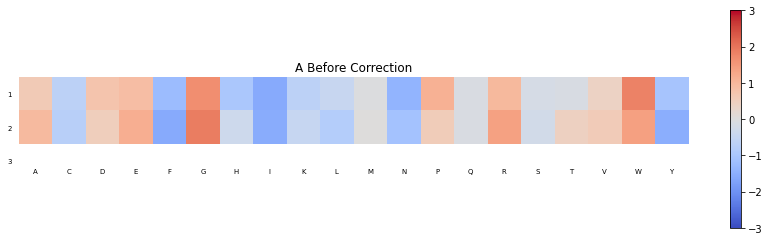

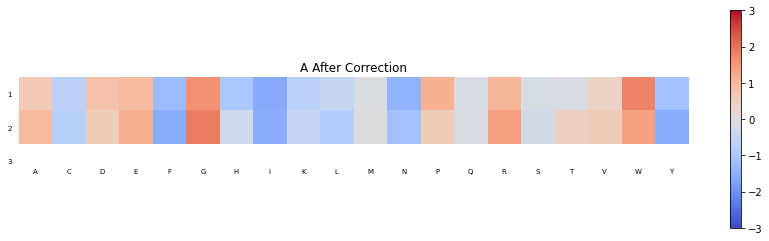

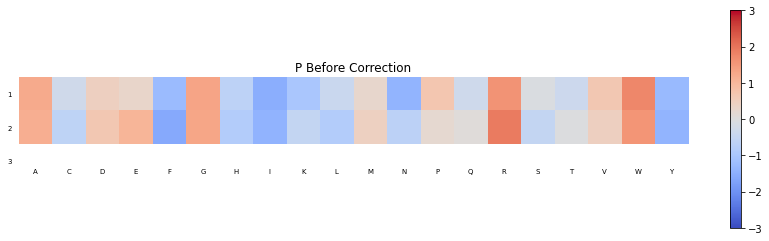

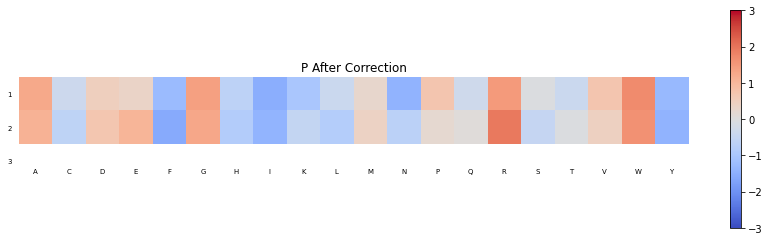

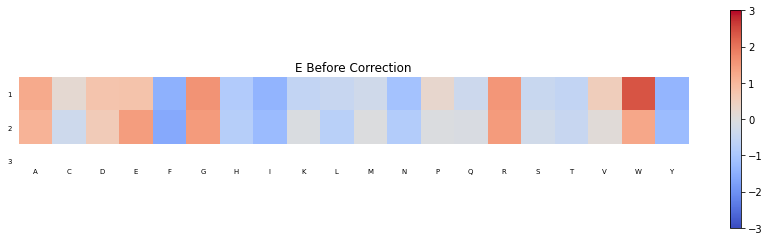

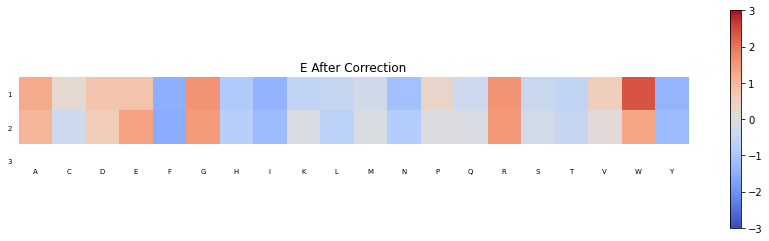

In [15]:
# A site

for site_type in ['A', 'P', 'E']:

    pause_scores, l_scores_0, l_scores_1 = process_experiment(densities1, zc, ypred[:,1], annotations, seq, pause_scores_aa, site_type)


    exp = f'{site_type}_pred'
    pause_score_benchmark[exp] = pause_scores
    L_score_benchmark0[exp] = l_scores_0
    L_score_benchmark1[exp] = l_scores_1

    pause_scores, l_scores_0, l_scores_1 = process_experiment(densities0, zc, ypred[:,0], annotations, seq, pause_scores_aa, site_type)

    exp = f'{site_type}_true'
    pause_score_benchmark[exp] = pause_scores
    L_score_benchmark0[exp] = l_scores_0
    L_score_benchmark1[exp] = l_scores_1

    def plot_pause_scores(pause_scores, title, pause_score_keys):
        """Plot the pause scores using a heatmap."""
        pause_scores_normalized = (pause_scores - np.average(pause_scores)) / np.std(pause_scores)

        fig, ax = plt.subplots(figsize=(15, 4))
        im = ax.imshow(pause_scores_normalized, cmap='coolwarm')
        ax.set_xticks(np.arange(len(pause_score_keys)))
        ax.set_xticklabels(labels=pause_score_keys, fontsize=7)
        ax.set_yticks(np.arange(3))
        ax.set_yticklabels(np.arange(1, 4))
        plt.xticks(fontname="Helvetica", fontsize=7)
        plt.yticks(fontname="Helvetica", fontsize=7)
        cbar = fig.colorbar(im, ax=ax)
        im.set_clim(-3, 3)
        ax.tick_params(left=False, bottom=False)
        plt.box(False)
        plt.title(title)
        plt.show()

    # Create pause score heatmaps
    exp_names = [f'{site_type}_pred', f'{site_type}_true']
    pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
    pause_score_keys = list(pause_scores_aa.keys())

    for i, score_type in enumerate(["Before", "After"]):
        pause_scores = np.vstack([pause_score_benchmark[exp_name][i, :] for exp_name in exp_names])
        plot_pause_scores(pause_scores, f"{site_type} {score_type} Correction", pause_score_keys)

In [11]:
pause_score_benchmark

{'A_pred': array([[1.27909429, 0.82080336, 1.33383492, 1.38310845, 0.62192703,
         1.66154841, 0.71392468, 0.49562211, 0.82106989, 0.89936016,
         1.05043587, 0.55999923, 1.46712531, 1.02589956, 1.41808591,
         1.00095564, 1.02051633, 1.20054617, 1.71640854, 0.68550348],
        [1.26602833, 0.82566853, 1.33618043, 1.37735648, 0.63120797,
         1.62679902, 0.71707753, 0.50037031, 0.82225443, 0.90093632,
         1.04051322, 0.55950874, 1.46112917, 1.03034057, 1.42173901,
         1.01242306, 1.02359954, 1.18891354, 1.69756452, 0.6803135 ]]),
 'A_true': array([[1.27909429, 0.82080336, 1.33383492, 1.38310845, 0.62192703,
         1.66154841, 0.71392468, 0.49562211, 0.82106989, 0.89936016,
         1.05043587, 0.55999923, 1.46712531, 1.02589956, 1.41808591,
         1.00095564, 1.02051633, 1.20054617, 1.71640854, 0.68550348],
        [1.25552788, 0.82452621, 1.32540819, 1.37179835, 0.63779624,
         1.6216987 , 0.7293103 , 0.51002963, 0.82155021, 0.90671849,
         

In [12]:
ypred[:100]

array([[0.00000000e+00, 3.48524898e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.10540789e-01],
       [0.00000000e+00, 3.39359730e-01],
       [0.00000000e+00, 5.10675311e-02],
       [0.00000000e+00, 8.03557038e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.99169075e-01],
       [0.00000000e+00, 2.47785047e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.81229782e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.67499804e-02],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.22192699e-01],
       [0.00000000e+00, 2.86319613e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.02501261e-01],
       [0.00000000e+00, 2.77160048e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.02314174e-01],
       [0.000000

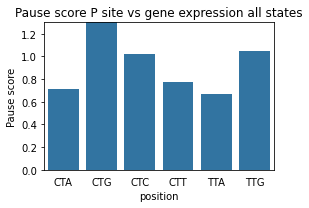

In [13]:
def plot_pause_score_bar_chart(pause_scores, codon_list, title):
    """Plot the pause scores as a bar chart."""
    df = pd.DataFrame(pause_scores)
    df = df[['AuxinA0FootprintR4_DNA_f']]
    yaxis_name = 'Pause score'
    df_long = df.melt(var_name='strain', value_name=yaxis_name)
    # df_long['position'] = codon_list * 3
    df_long['position'] = codon_list

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.barplot(x='position', y=yaxis_name, hue='strain', data=df_long)

    plt.ylim([0, 1.3])
    plt.legend([], [], frameon=False)
    plt.title(title)
    fig.tight_layout()
    ax.tick_params(bottom=False)
    plt.show()

# Create the bar chart of pause scores
H_codon_list = ['CTA', 'CTG', 'CTC', 'CTT', 'TTA', 'TTG']
plot_pause_score_bar_chart(L_score_benchmark1, H_codon_list, 'Pause score P site vs gene expression all states')

In [15]:
def calculate_dms_score(filepath, file_io, exp_name, dwig_suffix, annotations, seq):
    """Calculate the DMS score."""
    # zc_dms = np.loadtxt(filepath['data_folder'] + filepath[exp_name] + file_io['z_index'], delimiter="\t")
    # ypred_dms = np.loadtxt(filepath['data_folder'] + 'Sym_' + filepath[exp_name] + file_io['y_pred'], delimiter="\t")
    # xc_dms = np.loadtxt(filepath['data_folder'] + filepath[exp_name] + file_io['x_input'], delimiter="\t")
    
    # zc_dms = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/zc.txt", delimiter="\t")
    zc_dms = zc
    xc_dms = np.loadtxt("/home/zzz0054/chen_data/Riboformer/datasets/AA/zc.txt", delimiter="\t")
    ypred_dms = ypred[:, 1]
    # Analyze the DMS dataset
    exp_name = 'DMS'
    dwig_dms = densities
    # dwig_dms = read_gene_densities(filepath['data_folder'], filepath[exp_name], dwig_suffix)

    dms_score = np.zeros(ypred_dms.shape)
    print(ypred_dms.shape)
    print(zc_dms.shape)
    print(xc_dms.shape)
    
    for i in range(len(zc_dms)):
        index = zc_dms[i, :].astype('int')
        if annotations[index[0]][2] == 1:
            w_temp = dwig_dms[int(annotations[index[0]][0]) - 1:(int(annotations[index[0]][1])), 1]
            # dms_score[i] = sum(w_temp[3 * (index[1] - 10):3 * (index[1] - 10) + 3])
            start = 3 * (index[1] - 10)
            end = start + 3
            if end <= len(w_temp):
                dms_score[i-1] = sum(w_temp[start:end])
            else:
                dms_score[i-1] = sum(w_temp[start:])
        else:
            w_temp = dwig_dms[int(annotations[index[0]][0]) - 1:(int(annotations[index[0]][1])), 2]
            w_temp = w_temp[::-1]
            # dms_score[i] = sum(w_temp[3 * (index[1] - 10):3 * (index[1] - 10) + 3])
            start = 3 * (index[1] - 10)
            end = start + 3
            if end <= len(w_temp):
                dms_score[i-1] = sum(w_temp[start:end])
            else:
                dms_score[i-1] = sum(w_temp[start:])

    return dms_score, xc_dms, ypred_dms

# Calculate the ribosome density for DMS datasets
exp_name_dms = 'exp1'
dms_score, xc_dms, ypred_dms = calculate_dms_score('a', 'b', exp_name_dms, 'd', annotations, seq)

(1090171,)
(1090171, 2)
(7267804, 2)


In [16]:
dms_score.shape, xc_dms.shape, ypred_dms.shape

((1090171,), (7267804, 2), (1090171,))

In [17]:
def plot_dms_scatter(dms_score, data, ylabel):
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.scatter(dms_score, data, s=0.5, c='#1f77b4', edgecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.02, 50000])
    plt.xlim([0.001, 50])

    dms_score_sort = np.argsort(dms_score)
    dms_sorted = np.array_split(dms_score_sort, 10)
    scatter_sorted = np.array([[np.mean(dms_score[x]), np.mean(data[x])] for x in dms_sorted])

    plt.plot(scatter_sorted[:, 0], scatter_sorted[:, 1], 's', color='red', markersize=2)
    plt.ylabel(ylabel)
    plt.show()

# Plot the first scatter plot
plot_data1 = (np.power(2, xc_dms[:, 20] / 100) - 32) / 10
plot_dms_scatter(dms_score, plot_data1, 'Uncorrected')

# Plot the second scatter plot
plot_data2 = (np.power(2, ypred_dms + 5) - 32) / 10
plot_dms_scatter(dms_score, plot_data2, 'Corrected')

IndexError: index 20 is out of bounds for axis 1 with size 2